## LightGBM Prediction of Home Credit Default Risk
Introduction: Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

The basis of this kernel was forked from Olivier on Kaggle, with additional added features that increased ROC AUC from 0.792 to 0.8005 local CV.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

https://www.kaggle.com/c/home-credit-default-risk

The objective of this is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

Supervised: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features.

Classification: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)



In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Features
Different groups of features either to delete or add after a few runs of LightGBM feature importance analysis

In [2]:
features_with_no_imp_at_least_twice = [
    'ACTIVE_CNT_CREDIT_PROLONG_SUM', 'ACTIVE_CREDIT_DAY_OVERDUE_MEAN', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_WEEK', 'BURO_CNT_CREDIT_PROLONG_SUM', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN', 'BURO_CREDIT_ACTIVE_nan_MEAN',
    'BURO_CREDIT_CURRENCY_currency 1_MEAN', 'BURO_CREDIT_CURRENCY_currency 2_MEAN', 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
    'BURO_CREDIT_CURRENCY_currency 4_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_DAY_OVERDUE_MAX', 'BURO_CREDIT_DAY_OVERDUE_MEAN',
    'BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN', 'BURO_CREDIT_TYPE_Interbank credit_MEAN', 'BURO_CREDIT_TYPE_Loan for business development_MEAN',
    'BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN', 'BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN',
    'BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN', 'BURO_CREDIT_TYPE_Mobile operator loan_MEAN',
    'BURO_CREDIT_TYPE_Real estate loan_MEAN', 'BURO_CREDIT_TYPE_Unknown type of loan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN',
    'BURO_MONTHS_BALANCE_MAX_MAX', 'BURO_STATUS_2_MEAN_MEAN', 'BURO_STATUS_3_MEAN_MEAN', 'BURO_STATUS_4_MEAN_MEAN', 'BURO_STATUS_5_MEAN_MEAN',
    'BURO_STATUS_nan_MEAN_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_AMT_DRAWINGS_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MAX',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM',
    'CC_AMT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_AMT_INST_MIN_REGULARITY_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'CC_AMT_PAYMENT_TOTAL_CURRENT_VAR',
    'CC_AMT_RECIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_MAX', 'CC_AMT_TOTAL_RECEIVABLE_MIN', 'CC_AMT_TOTAL_RECEIVABLE_SUM', 'CC_AMT_TOTAL_RECEIVABLE_VAR',
    'CC_CNT_DRAWINGS_ATM_CURRENT_MIN', 'CC_CNT_DRAWINGS_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MAX', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN',
    'CC_CNT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'CC_CNT_DRAWINGS_OTHER_CURRENT_VAR', 'CC_CNT_DRAWINGS_POS_CURRENT_SUM',
    'CC_CNT_INSTALMENT_MATURE_CUM_MAX', 'CC_CNT_INSTALMENT_MATURE_CUM_MIN', 'CC_COUNT', 'CC_MONTHS_BALANCE_MAX', 'CC_MONTHS_BALANCE_MEAN',
    'CC_MONTHS_BALANCE_MIN', 'CC_MONTHS_BALANCE_SUM', 'CC_NAME_CONTRACT_STATUS_Active_MAX', 'CC_NAME_CONTRACT_STATUS_Active_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_MAX', 'CC_NAME_CONTRACT_STATUS_Approved_MEAN', 'CC_NAME_CONTRACT_STATUS_Approved_MIN',
    'CC_NAME_CONTRACT_STATUS_Approved_SUM', 'CC_NAME_CONTRACT_STATUS_Approved_VAR', 'CC_NAME_CONTRACT_STATUS_Completed_MAX',
    'CC_NAME_CONTRACT_STATUS_Completed_MEAN', 'CC_NAME_CONTRACT_STATUS_Completed_MIN', 'CC_NAME_CONTRACT_STATUS_Completed_SUM', 'CC_NAME_CONTRACT_STATUS_Completed_VAR',
    'CC_NAME_CONTRACT_STATUS_Demand_MAX', 'CC_NAME_CONTRACT_STATUS_Demand_MEAN', 'CC_NAME_CONTRACT_STATUS_Demand_MIN', 'CC_NAME_CONTRACT_STATUS_Demand_SUM',
    'CC_NAME_CONTRACT_STATUS_Demand_VAR', 'CC_NAME_CONTRACT_STATUS_Refused_MAX', 'CC_NAME_CONTRACT_STATUS_Refused_MEAN', 'CC_NAME_CONTRACT_STATUS_Refused_MIN',
    'CC_NAME_CONTRACT_STATUS_Refused_SUM', 'CC_NAME_CONTRACT_STATUS_Refused_VAR', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_MEAN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN', 'CC_NAME_CONTRACT_STATUS_Sent proposal_SUM',
    'CC_NAME_CONTRACT_STATUS_Sent proposal_VAR', 'CC_NAME_CONTRACT_STATUS_Signed_MAX', 'CC_NAME_CONTRACT_STATUS_Signed_MEAN', 'CC_NAME_CONTRACT_STATUS_Signed_MIN',
    'CC_NAME_CONTRACT_STATUS_Signed_SUM', 'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
    'CC_NAME_CONTRACT_STATUS_nan_MIN', 'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR', 'CC_SK_DPD_DEF_MAX',
    'CC_SK_DPD_DEF_MIN', 'CC_SK_DPD_DEF_SUM', 'CC_SK_DPD_DEF_VAR', 'CC_SK_DPD_MAX', 'CC_SK_DPD_MEAN', 'CC_SK_DPD_MIN', 'CC_SK_DPD_SUM',
    'CC_SK_DPD_VAR', 'CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN', 'CLOSED_AMT_CREDIT_SUM_LIMIT_SUM', 'CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'CLOSED_CNT_CREDIT_PROLONG_SUM', 'CLOSED_CREDIT_DAY_OVERDUE_MAX', 'CLOSED_CREDIT_DAY_OVERDUE_MEAN', 'CLOSED_MONTHS_BALANCE_MAX_MAX',
    'CNT_CHILDREN', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes', 'ENTRANCES_MODE', 'FLAG_CONT_MOBILE',
    'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLOORSMAX_MODE',
    'FONDKAPREMONT_MODE_not specified', 'FONDKAPREMONT_MODE_org spec account', 'FONDKAPREMONT_MODE_reg oper account', 'FONDKAPREMONT_MODE_reg oper spec account',
    'HOUSETYPE_MODE_block of flats', 'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house', 'LIVE_REGION_NOT_WORK_REGION',
    'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Single / not married',
    'NAME_FAMILY_STATUS_Unknown', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Co-op apartment', 'NAME_HOUSING_TYPE_With parents',
    'NAME_INCOME_TYPE_Businessman', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Student',
    'NAME_INCOME_TYPE_Unemployed', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people',
    'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied',
    'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MEAN', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_SUM', 'NEW_RATIO_BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
    'NEW_RATIO_BURO_CNT_CREDIT_PROLONG_SUM', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MAX', 'NEW_RATIO_BURO_CREDIT_DAY_OVERDUE_MEAN', 'NEW_RATIO_BURO_MONTHS_BALANCE_MAX_MAX',
    'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MIN', 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MAX', 'OCCUPATION_TYPE_Cleaning staff', 'OCCUPATION_TYPE_Cooking staff',
    'OCCUPATION_TYPE_HR staff', 'OCCUPATION_TYPE_IT staff', 'OCCUPATION_TYPE_Low-skill Laborers', 'OCCUPATION_TYPE_Managers',
    'OCCUPATION_TYPE_Private service staff', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Sales staff', 'OCCUPATION_TYPE_Secretaries',
    'OCCUPATION_TYPE_Security staff', 'OCCUPATION_TYPE_Waiters/barmen staff', 'ORGANIZATION_TYPE_Advertising', 'ORGANIZATION_TYPE_Agriculture',
    'ORGANIZATION_TYPE_Business Entity Type 1', 'ORGANIZATION_TYPE_Business Entity Type 2', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Culture',
    'ORGANIZATION_TYPE_Electricity', 'ORGANIZATION_TYPE_Emergency', 'ORGANIZATION_TYPE_Government', 'ORGANIZATION_TYPE_Hotel', 'ORGANIZATION_TYPE_Housing',
    'ORGANIZATION_TYPE_Industry: type 1', 'ORGANIZATION_TYPE_Industry: type 10', 'ORGANIZATION_TYPE_Industry: type 11', 'ORGANIZATION_TYPE_Industry: type 12',
    'ORGANIZATION_TYPE_Industry: type 13', 'ORGANIZATION_TYPE_Industry: type 2', 'ORGANIZATION_TYPE_Industry: type 3', 'ORGANIZATION_TYPE_Industry: type 4',
    'ORGANIZATION_TYPE_Industry: type 5', 'ORGANIZATION_TYPE_Industry: type 6', 'ORGANIZATION_TYPE_Industry: type 7', 'ORGANIZATION_TYPE_Industry: type 8',
    'ORGANIZATION_TYPE_Insurance', 'ORGANIZATION_TYPE_Legal Services', 'ORGANIZATION_TYPE_Mobile', 'ORGANIZATION_TYPE_Other', 'ORGANIZATION_TYPE_Postal',
    'ORGANIZATION_TYPE_Realtor', 'ORGANIZATION_TYPE_Religion', 'ORGANIZATION_TYPE_Restaurant', 'ORGANIZATION_TYPE_Security',
    'ORGANIZATION_TYPE_Security Ministries', 'ORGANIZATION_TYPE_Services', 'ORGANIZATION_TYPE_Telecom', 'ORGANIZATION_TYPE_Trade: type 1',
    'ORGANIZATION_TYPE_Trade: type 2', 'ORGANIZATION_TYPE_Trade: type 3', 'ORGANIZATION_TYPE_Trade: type 4', 'ORGANIZATION_TYPE_Trade: type 5',
    'ORGANIZATION_TYPE_Trade: type 6', 'ORGANIZATION_TYPE_Trade: type 7',
    'ORGANIZATION_TYPE_Transport: type 1', 'ORGANIZATION_TYPE_Transport: type 2', 'ORGANIZATION_TYPE_Transport: type 4', 'ORGANIZATION_TYPE_University',
    'ORGANIZATION_TYPE_XNA', 'POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN', 'POS_NAME_CONTRACT_STATUS_Approved_MEAN', 'POS_NAME_CONTRACT_STATUS_Canceled_MEAN',
    'POS_NAME_CONTRACT_STATUS_Demand_MEAN', 'POS_NAME_CONTRACT_STATUS_XNA_MEAN', 'POS_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_CHANNEL_TYPE_Car dealer_MEAN',
    'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_CLIENT_MEAN', 'PREV_CODE_REJECT_REASON_SYSTEM_MEAN', 'PREV_CODE_REJECT_REASON_VERIF_MEAN',
    'PREV_CODE_REJECT_REASON_XNA_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_N_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN',
    'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Business development_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a garage_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a home_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Buying a new car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Buying a used car_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Education_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Everyday expenses_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Furniture_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Hobby_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Journey_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Money for a third person_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Other_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Payments on other loans_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_MEAN',
    'PREV_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_XAP_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_XNA_MEAN',
    'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_Unused offer_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_CONTRACT_TYPE_XNA_MEAN',
    'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_Additional Service_MEAN', 'PREV_NAME_GOODS_CATEGORY_Animals_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Auto Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Clothing and Accessories_MEAN', 'PREV_NAME_GOODS_CATEGORY_Construction Materials_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Direct Sales_MEAN', 'PREV_NAME_GOODS_CATEGORY_Education_MEAN', 'PREV_NAME_GOODS_CATEGORY_Fitness_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Gardening_MEAN', 'PREV_NAME_GOODS_CATEGORY_Homewares_MEAN', 'PREV_NAME_GOODS_CATEGORY_House Construction_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Insurance_MEAN', 'PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN', 'PREV_NAME_GOODS_CATEGORY_Medical Supplies_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Medicine_MEAN', 'PREV_NAME_GOODS_CATEGORY_Office Appliances_MEAN', 'PREV_NAME_GOODS_CATEGORY_Other_MEAN', 'PREV_NAME_GOODS_CATEGORY_Tourism_MEAN',
    'PREV_NAME_GOODS_CATEGORY_Vehicles_MEAN', 'PREV_NAME_GOODS_CATEGORY_Weapon_MEAN', 'PREV_NAME_GOODS_CATEGORY_XNA_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN',
    'PREV_NAME_PAYMENT_TYPE_Cashless from the account of the employer_MEAN', 'PREV_NAME_PAYMENT_TYPE_Non-cash from your account_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN',
    'PREV_NAME_PORTFOLIO_Cars_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Construction_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Furniture_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Industry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_Jewelry_MEAN', 'PREV_NAME_SELLER_INDUSTRY_MLM partners_MEAN',
    'PREV_NAME_SELLER_INDUSTRY_Tourism_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_TYPE_SUITE_Group of people_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN',
    'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN', 'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN',
    'PREV_PRODUCT_COMBINATION_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'REFUSED_AMT_DOWN_PAYMENT_MAX', 'REFUSED_AMT_DOWN_PAYMENT_MEAN',
    'REFUSED_RATE_DOWN_PAYMENT_MIN', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
    'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
    'WALLSMATERIAL_MODE_Wooden', 'WEEKDAY_APPR_PROCESS_START_FRIDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY'
]

*Top features from original run*

In [3]:
top90=['NEW_EXT_SOURCES_MEAN', 'prev_score_mean', 'buro_score_sum',
       'buro_score_mean', 'INTEREST', 'prev_score_max',
       'app EXT_SOURCE_1 / DAYS_BIRTH', 'AMT_ANNUITY',
       'app EXT_SOURCE_2 * DAYS_EMPLOYED', 'CNT_PAYMENT', 'DAYS_BIRTH',
       'app EXT_SOURCE_2 * EXT_SOURCE_3', 'NEW_CREDIT_TO_GOODS_RATIO',
       'buro_score_recent2y_sum', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'CODE_GENDER',
       'LATE_PAYMENT', 'EXT_SOURCE_2', 'prev_score_last',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_MAX', 'CRED_UTIL_2', 'AMT_CREDIT',
       'DAYS_ID_PUBLISH', 'buro_score_max', 'app EXT_SOURCE_3 / DAYS_BIRTH',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'app EXT_SOURCE_3 * DAYS_EMPLOYED',
       'NAME_EDUCATION_TYPE_Higher education', 'app EXT_SOURCE_2 / DAYS_BIRTH',
       'NEW_ANNUITY_TO_INCOME_RATIO', 'REGION_POPULATION_RELATIVE',
       'PREV_days_late_due_MIN', 'DAYS_EMPLOYED',
       'BURO_AMT_CREDIT_DEBT_RATE_VAR', 'INSTAL_AMT_PAYMENT_SUM',
       'buro_score_var', 'POS_MONTHS_BALANCE_MAX', 'CLOSED_DAYS_CREDIT_MAX',
       'DAYS_REGISTRATION', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'OWN_CAR_AGE',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'prev_score_var', 'INSTAL_DPD_MEAN',
       'POS_MONTHS_BALANCE_MEAN', 'APPROVED_DAYS_DECISION_MAX', 'EXT_SOURCE_3',
       'INTEREST_SHARE', 'NEW_CREDIT_TO_ANNUITY_RATIO/3',
       'INSTAL_AMT_PAYMENT_MIN', 'app EXT_SOURCE_1 * EXT_SOURCE_2',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'NAME_FAMILY_STATUS_Married',
       '60_DAYSAMT_PAYMENT_MIN', 'NEW_CAR_TO_BIRTH_RATIO',
       'ACTIVE_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
       'buro_score_last', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'prev_score_recent2y_sum', 'INSTAL_AMT_PAYMENT_MEAN',
       'NEW_PHONE_TO_EMPLOY_RATIO', 'REGION_RATING_CLIENT_W_CITY',
       'POS_MONTHS_BALANCE_SIZE', 'INSTAL_DBD_MEAN',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'PREV_days_late_due_MEAN', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN',
       'AMT_GOODS_PRICE', 'CLOSED_AMT_CREDIT_SUM_MEAN',
       'NEW_PHONE_TO_BIRTH_RATIO', 'INSTAL_AMT_INSTALMENT_SUM',
       'NEW_DOC_IND_KURT', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
       'PREV_DAYS_DECISION_MEAN', 'PREV_DAYS_DECISION_MAX',
       'APPROVED_AMT_DOWN_PAYMENT_MAX', 'NEW_SOURCES_PROD',
       'APPROVED_DAYS_DECISION_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'NEW_SCORES_STD',
       'NEW_CREDIT_TO_INCOME_RATIO', 'BURO_AMT_CREDIT_DEBT_RATE_MAX',
       'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'INSTAL_PAYMENT_DIFF_MEAN', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
       'NEW_RATIO_BURO_DAYS_CREDIT_MAX',
       'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'INSTAL_DBD_SUM',
       'PREV_APP_CREDIT_PERC_VAR', 'NEW_CAR_TO_EMPLOY_RATIO',
       'BURO_DAYS_CREDIT_MAX', 'INSTAL_PAYMENT_PERC_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
       'ACTIVE_AMT_CREDIT_DEBT_RATE_VAR', 'APPROVED_INTEREST_SHARE_MEAN',
       'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX']

400 random features

In [4]:
rand=['OCCUPATION_TYPE_Laborers',
 'CC_CNT_DRAWINGS_CURRENT_MEAN',
 'PREV_NAME_CONTRACT_TYPE_Consumer loans_MEAN',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MIN',
 'NEW_RATIO_PREV_DAYS_DECISION_MIN',
 'REFUSED_6MAMT_ANNUITY_MAX',
 'PREV_length_of_loan_MAX',
 'PREV_CHANNEL_TYPE_Stone_MEAN',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'REFUSED_3MAMT_ANNUITY_MAX',
 '60_DAYSDBD_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Computers_MEAN',
 'REFUSED_3MCNT_PAYMENT_SUM',
 '180_DAYSDBD_SUM',
 'PREV_NAME_PORTFOLIO_Cards_MEAN',
 'CC_AMT_DRAWINGS_ATM_CURRENT_SUM',
 'CC_CNT_DRAWINGS_POS_CURRENT_VAR',
 'NEW_RATIO_PREV_INTEREST_SHARE_MAX',
 'NEW_RATIO_PREV_AMT_DOWN_PAYMENT_MAX',
 'BURO_AMT_CREDIT_SUM_DEBT_SUM',
 'NAME_HOUSING_TYPE_House / apartment',
 'NEW_RATIO_PREV_APP_CREDIT_PERC_MEAN',
 'APPROVED_AMT_ANNUITY_MIN',
 'PREV_NAME_PORTFOLIO_POS_MEAN',
 'PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'REFUSED_AMT_CREDIT_MEAN',
 'CC_AMT_BALANCE_VAR',
 'CLOSED_AMT_CREDIT_SUM_DEBT_MEAN',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'ACTIVE_AMT_CREDIT_DEBT_RATE_MIN',
 'CLOSED_DAYS_CREDIT_VAR',
 '60_DAYSAMT_INSTALMENT_MEAN',
 'REFUSED_6MAMT_DOWN_PAYMENT_MAX',
 'REFUSED_3Mapplication_div_credit_MIN',
 'REFUSED_3MHOUR_APPR_PROCESS_START_MEAN',
 'APPROVED_AMT_DOWN_PAYMENT_MIN',
 'REFUSED_AMT_DOWN_PAYMENT_MIN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'REFUSED_AMT_APPLICATION_MAX',
 'REFUSED_3MAMT_CREDIT_MIN',
 'PREV_NAME_PORTFOLIO_Cash_MEAN',
 'NONLIVINGAPARTMENTS_MEDI',
 'PREV_AMT_GOODS_PRICE_MEAN',
 'YEARS_BEGINEXPLUATATION_MODE',
 'CC_AMT_PAYMENT_CURRENT_MIN',
 'APPROVED_CNT_PAYMENT_MEAN',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'DEBT_RATIO_y',
 'REFUSED_DAYS_DECISION_MIN',
 'CC_NAME_CONTRACT_STATUS_Active_MEAN',
 'REFUSED_3MAPP_CREDIT_PERC_VAR',
 'CC_CNT_DRAWINGS_CURRENT_SUM',
 'CLOSED_AMT_ANNUITY_MEAN',
 'NEW_RATIO_PREV_CNT_PAYMENT_MEAN',
 'REFUSED_3MAMT_DOWN_PAYMENT_MIN',
 'ORGANIZATION_TYPE_Bank',
 'REFUSED_3MINTEREST_SHARE_MIN',
 'PREV_CODE_REJECT_REASON_XAP_MEAN',
 'CC_AMT_DRAWINGS_CURRENT_SUM',
 'POS_SK_DPD_DEF_MEAN',
 'PREV_PRODUCT_COMBINATION_Cash_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_XNA_MEAN',
 'NEW_RATIO_BURO_MONTHS_BALANCE_SIZE_SUM',
 'CC_CNT_INSTALMENT_MATURE_CUM_SUM',
 'REG_CITY_NOT_LIVE_CITY',
 'BURO_AMT_ANNUITY_MAX',
 'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN',
 'CC_AMT_DRAWINGS_CURRENT_MEAN',
 'FLOORSMAX_AVG',
 'REFUSED_3MHOUR_APPR_PROCESS_START_MIN',
 'NEW_RATIO_PREV_PREV_CRED_TO_ANNUITY_RATIO_MEAN',
 'APPROVED_INTEREST_SHARE_MEAN',
 'INSTAL_PAYMENT_DIFF_VAR',
 'CC_AMT_TOTAL_RECEIVABLE_MEAN',
 'BURO_AMT_CREDIT_DEBT_RATE_MEAN',
 'REFUSED_3MAMT_GOODS_PRICE_MEAN',
 '60_DAYSPAYMENT_DIFF_SUM',
 'PREV_length_of_loan_MIN',
 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'INSTAL_PAYMENT_PERC_MAX',
 'REFUSED_6MAPP_CREDIT_PERC_MIN',
 'REFUSED_3MDAYS_DECISION_MEAN',
 'CC_AMT_BALANCE_MIN',
 'PREV_NAME_GOODS_CATEGORY_Audio/Video_MEAN',
 'PREV_NAME_TYPE_SUITE_Children_MEAN',
 'CLOSED_MONTHS_BALANCE_SIZE_SUM',
 'FLAG_PHONE',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_MEAN',
 'PREV_APP_CREDIT_PERC_MIN',
 'CC_CNT_DRAWINGS_POS_CURRENT_MIN',
 'BURO_CREDIT_TYPE_Car loan_MEAN',
 'PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN',
 'CC_AMT_DRAWINGS_POS_CURRENT_MIN',
 'FLOORSMIN_MODE',
 'ACTIVE_CREDIT_DAY_OVERDUE_MAX',
 'CLOSED_DAYS_CREDIT_ENDDATE_MEAN',
 '60_DAYSDPD_MEAN',
 'APPROVED_DAYS_DECISION_MIN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MAX',
 'APPROVED_days_late_due_MEAN',
 'CC_AMT_PAYMENT_CURRENT_MEAN',
 'REFUSED_6MPREV_CRED_TO_ANNUITY_RATIO_MEAN',
 'BURO_STATUS_C_MEAN_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'REFUSED_6MDAYS_DECISION_MEAN',
 'CC_AMT_DRAWINGS_CURRENT_MAX',
 'REFUSED_INTEREST_SHARE_MEAN',
 'REFUSED_6MAMT_ANNUITY_MEAN',
 'APARTMENTS_AVG',
 '90_DAYSDPD_SUM',
 'PREV_PRODUCT_COMBINATION_Cash Street: low_MEAN',
 'NEW_RATIO_PREV_AMT_APPLICATION_MAX',
 'NAME_HOUSING_TYPE_Rented apartment',
 'REFUSED_INTEREST_SHARE_MAX',
 'NEW_LIVE_IND_SUM',
 'FLAG_WORK_PHONE',
 'REFUSED_6MAMT_CREDIT_MAX',
 'PREV_CNT_PAYMENT_SUM',
 'PREV_CHANNEL_TYPE_AP+ (Cash loan)_MEAN',
 'APPROVED_INTEREST_SHARE_MAX',
 'PREV_WEEKDAY_APPR_PROCESS_START_THURSDAY_MEAN',
 'CC_NAME_CONTRACT_STATUS_Active_VAR',
 'CC_AMT_DRAWINGS_POS_CURRENT_MAX',
 'REFUSED_6MAMT_APPLICATION_MEAN',
 '60_DAYSAMT_INSTALMENT_MAX',
 'REFUSED_3MAMT_APPLICATION_MAX',
 'NEW_RATIO_PREV_INTEREST_SHARE_MEAN',
 'REFUSED_3MAPP_CREDIT_PERC_MIN',
 '180_DAYSDAYS_ENTRY_PAYMENT_SUM',
 'REFUSED_3MAMT_DOWN_PAYMENT_MEAN',
 'REFUSED_6MAMT_DOWN_PAYMENT_MIN',
 'PREV_length_of_loan_MEAN',
 'CLOSED_MONTHS_BALANCE_MIN_MIN',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'LIVINGAREA_MODE',
 'LIVINGAPARTMENTS_AVG',
 'REFUSED_6MCNT_PAYMENT_MEAN',
 '90_DAYSAMT_PAYMENT_MAX',
 'NEW_RATIO_PREV_INTEREST_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'FLAG_OWN_REALTY',
 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
 'REFUSED_3MINTEREST_SHARE_MAX',
 'BURO_DAYS_CREDIT_MIN',
 'COMMONAREA_MODE',
 'LIVINGAREA_MEDI',
 'PREV_AMT_APPLICATION_MIN',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 '90_DAYSDBD_SUM',
 'BURO_AMT_CREDIT_SUM_LIMIT_SUM',
 'CC_SK_DPD_DEF_MEAN',
 'POS_NAME_CONTRACT_STATUS_Returned to the store_MEAN',
 'CC_AMT_RECEIVABLE_PRINCIPAL_MIN',
 'PREV_NAME_TYPE_SUITE_Spouse, partner_MEAN',
 'NEW_RATIO_PREV_application_div_credit_MIN',
 'PREV_application_div_credit_MIN',
 'INSTAL_PAYMENT_PERC_SUM',
 'PREV_PRODUCT_COMBINATION_POS household without interest_MEAN',
 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR',
 'PREV_NAME_CONTRACT_STATUS_Canceled_MEAN',
 'NEW_RATIO_PREV_AMT_CREDIT_MIN',
 'NEW_RATIO_PREV_AMT_APPLICATION_MIN',
 'PREV_PREV_CRED_TO_ANNUITY_RATIO_MEAN',
 'APPROVED_INTEREST_MAX',
 '90_DAYSAMT_PAYMENT_MIN',
 'LANDAREA_MEDI',
 'REFUSED_AMT_GOODS_PRICE_MEAN',
 'APPROVED_application_div_credit_MEAN',
 'INSTAL_AMT_PAYMENT_MAX',
 'NEW_RATIO_PREV_HOUR_APPR_PROCESS_START_MEAN',
 'NAME_INCOME_TYPE_State servant',
 'APPROVED_AMT_GOODS_PRICE_MAX',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 '90_DAYSDPD_MEAN',
 'REFUSED_6MAMT_APPLICATION_MIN',
 'NAME_INCOME_TYPE_Working',
 'NEW_RATIO_BURO_MONTHS_BALANCE_MIN_MIN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
 'PREV_NAME_CASH_LOAN_PURPOSE_Medicine_MEAN',
 'NEW_RATIO_PREV_INTEREST_MAX',
 'NEW_RATIO_BURO_DAYS_CREDIT_VAR',
 '180_DAYSPAYMENT_DIFF_VAR',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'PREV_NAME_CLIENT_TYPE_New_MEAN',
 'REFUSED_AMT_GOODS_PRICE_MIN',
 'REFUSED_6MRATE_DOWN_PAYMENT_MAX',
 '90_DAYSPAYMENT_PERC_SUM',
 'ACTIVE_DAYS_CREDIT_MIN',
 'POS_COUNT',
 'INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE',
 'REFUSED_6MAMT_GOODS_PRICE_MEAN',
 'NEW_RATIO_BURO_DAYS_CREDIT_MIN',
 'ACTIVE_MONTHS_BALANCE_SIZE_MEAN',
 'APPROVED_RATE_DOWN_PAYMENT_MEAN',
 'NEW_RATIO_BURO_AMT_CREDIT_DEBT_RATE_MIN',
 '90_DAYSPAYMENT_DIFF_MAX',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'REFUSED_3MINTEREST_SHARE_MEAN',
 'CLOSED_DAYS_CREDIT_UPDATE_MEAN',
 'NEW_DOC_IND_STD',
 'DEBT_RATIO_x',
 'REFUSED_3Mapplication_div_credit_MAX',
 'NEW_RATIO_PREV_AMT_GOODS_PRICE_MEAN',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX',
 'APPROVED_days_late_due_MIN',
 'APPROVED_application_div_credit_MIN',
 'INSTAL_PAYMENT_DIFF_MEAN',
 'APPROVED_INTEREST_MEAN',
 '60_DAYSAMT_PAYMENT_MEAN',
 'REFUSED_HOUR_APPR_PROCESS_START_MIN',
 'PREV_CHANNEL_TYPE_Regional / Local_MEAN',
 '90_DAYSAMT_PAYMENT_MEAN',
 'REFUSED_6MAPP_CREDIT_PERC_VAR',
 'REFUSED_3MRATE_DOWN_PAYMENT_MEAN',
 'PREV_APP_CREDIT_PERC_MEAN',
 'app EXT_SOURCE_1 * DAYS_EMPLOYED',
 'YEARS_BEGINEXPLUATATION_AVG',
 'PREV_CODE_REJECT_REASON_SCOFR_MEAN',
 '90_DAYSDAYS_ENTRY_PAYMENT_MEAN',
 'NEW_RATIO_PREV_RATE_DOWN_PAYMENT_MEAN',
 'REFUSED_3MAMT_APPLICATION_MEAN',
 'NEW_INC_BY_ORG',
 'CC_AMT_INST_MIN_REGULARITY_MEAN',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_SUM',
 'PREV_CHANNEL_TYPE_Country-wide_MEAN',
 'ENTRANCES_MEDI',
 'PREV_INTEREST_MAX',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'CC_AMT_BALANCE_SUM',
 'NEW_RATIO_BURO_DAYS_CREDIT_ENDDATE_MIN',
 'PREV_NAME_CLIENT_TYPE_Refreshed_MEAN',
 'NONLIVINGAREA_MEDI',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'REFUSED_APP_CREDIT_PERC_MEAN',
 'REFUSED_3MAMT_GOODS_PRICE_MAX',
 'REFUSED_AMT_CREDIT_MAX',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 '180_DAYSDAYS_ENTRY_PAYMENT_MEAN',
 'NEW_RATIO_BURO_AMT_CREDIT_DEBT_RATE_SUM',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
 'NEW_RATIO_PREV_APP_CREDIT_PERC_MIN',
 'CC_AMT_RECIVABLE_MEAN',
 'NONLIVINGAREA_AVG',
 'PREV_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_MEAN',
 'REFUSED_INTEREST_MEAN',
 'REFUSED_3MAMT_APPLICATION_MIN',
 'POS_SK_DPD_DEF_MAX',
 '60_DAYSDAYS_ENTRY_PAYMENT_MEAN',
 '180_DAYSAMT_PAYMENT_MEAN',
 'PREV_NAME_GOODS_CATEGORY_Sport and Leisure_MEAN',
 'PREV_NAME_PAYMENT_TYPE_Cash through the bank_MEAN',
 'OCCUPATION_TYPE_Core staff',
 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM',
 'CC_AMT_PAYMENT_CURRENT_MAX',
 'COMMONAREA_MEDI',
 '180_DAYSDBD_MEAN',
 'CC_AMT_INST_MIN_REGULARITY_SUM',
 'CLOSED_DAYS_CREDIT_MIN',
 'APPROVED_APP_CREDIT_PERC_VAR',
 'APPROVED_HOUR_APPR_PROCESS_START_MAX',
 'APPROVED_AMT_APPLICATION_MEAN',
 'PREV_NAME_CONTRACT_TYPE_Revolving loans_MEAN',
 'APPROVED_AMT_APPLICATION_MAX',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_MAX',
 'NEW_RATIO_PREV_AMT_CREDIT_MEAN',
 '90_DAYSDPD_MAX',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_MIN',
 'NEW_RATIO_BURO_AMT_CREDIT_DEBT_RATE_MAX',
 '90_DAYSAMT_INSTALMENT_SUM',
 'REFUSED_HOUR_APPR_PROCESS_START_MEAN',
 'REFUSED_AMT_ANNUITY_MIN',
 'PREV_APP_CREDIT_PERC_MAX',
 '90_DAYSDBD_MEAN',
 'ORGANIZATION_TYPE_Transport: type 3',
 'PREV_NAME_CASH_LOAN_PURPOSE_Urgent needs_MEAN',
 'CC_NAME_CONTRACT_STATUS_Active_SUM',
 'APPROVED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'APPROVED_length_of_loan_MEAN',
 'PREV_NAME_PORTFOLIO_XNA_MEAN',
 '60_DAYSPAYMENT_PERC_SUM',
 'BASEMENTAREA_MEDI',
 'PREV_AMT_GOODS_PRICE_MAX',
 '60_DAYSPAYMENT_DIFF_MEAN',
 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN',
 'REFUSED_3MRATE_DOWN_PAYMENT_MIN',
 'PREV_NAME_TYPE_SUITE_Other_A_MEAN',
 'NAME_INCOME_TYPE_Commercial associate',
 'APPROVED_AMT_ANNUITY_MEAN',
 'CNT_FAM_MEMBERS',
 'APPROVED_APP_CREDIT_PERC_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'ACTIVE_DAYS_CREDIT_VAR',
 'PREV_NAME_GOODS_CATEGORY_Consumer Electronics_MEAN',
 'NEW_RATIO_PREV_HOUR_APPR_PROCESS_START_MIN',
 'NEW_INC_PER_CHLD',
 'BURO_MONTHS_BALANCE_SIZE_SUM',
 'REFUSED_6MDAYS_DECISION_MAX',
 'LANDAREA_AVG',
 'REFUSED_3MRATE_DOWN_PAYMENT_MAX',
 'ACTIVE_MONTHS_BALANCE_SIZE_SUM',
 'LIVE_CITY_NOT_WORK_CITY',
 'OCCUPATION_TYPE_Accountants',
 'PREV_NAME_CONTRACT_TYPE_Cash loans_MEAN',
 'PREV_PRODUCT_COMBINATION_Cash X-Sell: high_MEAN',
 '90_DAYSDAYS_ENTRY_PAYMENT_SUM',
 'REFUSED_PREV_CRED_TO_ANNUITY_RATIO_MIN',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 '180_DAYSAMT_INSTALMENT_MEAN',
 'REFUSED_6MCNT_PAYMENT_SUM',
 'REFUSED_3MAPP_CREDIT_PERC_MAX',
 'PREV_WEEKDAY_APPR_PROCESS_START_SATURDAY_MEAN',
 'NEW_RATIO_PREV_AMT_ANNUITY_MIN',
 'REFUSED_6MAMT_CREDIT_MEAN',
 'CC_AMT_RECIVABLE_VAR',
 'CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN',
 'NEW_RATIO_PREV_CNT_PAYMENT_SUM',
 'BURO_MONTHS_BALANCE_MIN_MIN',
 'REFUSED_6MAPP_CREDIT_PERC_MEAN',
 'app EXT_SOURCE_1 * EXT_SOURCE_3',
 'PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN',
 'NEW_RATIO_BURO_MONTHS_BALANCE_SIZE_MEAN',
 'PREV_PRODUCT_COMBINATION_Card Street_MEAN',
 'PREV_AMT_CREDIT_MAX',
 'LIVINGAPARTMENTS_MODE',
 'REFUSED_application_div_credit_MIN',
 'PREV_NAME_SELLER_INDUSTRY_XNA_MEAN',
 'POS_SK_DPD_MAX',
 'TOTALAREA_MODE',
 'REFUSED_3MPREV_CRED_TO_ANNUITY_RATIO_MAX',
 '60_DAYSAMT_PAYMENT_SUM',
 'APPROVED_AMT_CREDIT_MAX',
 '60_DAYSPAYMENT_PERC_MAX',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_VAR',
 'NEW_RATIO_BURO_DAYS_CREDIT_UPDATE_MEAN',
 'CC_CNT_DRAWINGS_POS_CURRENT_MAX',
 'REFUSED_3MAMT_CREDIT_MEAN',
 'REFUSED_6MAPP_CREDIT_PERC_MAX',
 'CC_AMT_RECEIVABLE_PRINCIPAL_MEAN',
 'REFUSED_6MHOUR_APPR_PROCESS_START_MAX',
 'PREV_NAME_GOODS_CATEGORY_Mobile_MEAN',
 'REFUSED_3MHOUR_APPR_PROCESS_START_MAX',
 'APPROVED_AMT_DOWN_PAYMENT_MAX',
 'CC_AMT_DRAWINGS_ATM_CURRENT_MEAN',
 'INSTAL_DPD_MAX',
 'PREV_INTEREST_MIN',
 'PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN',
 'ACTIVE_MONTHS_BALANCE_MIN_MIN',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'CLOSED_DAYS_CREDIT_MEAN',
 'HOUR_APPR_PROCESS_START',
 'REFUSED_6MAMT_GOODS_PRICE_MIN',
 '60_DAYSDBD_SUM',
 'REFUSED_3MAMT_DOWN_PAYMENT_MAX',
 'BURO_MONTHS_BALANCE_SIZE_MEAN',
 'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
 'BASEMENTAREA_AVG',
 'APPROVED_INTEREST_MIN',
 'YEARS_BUILD_AVG',
 'FLOORSMIN_MEDI',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_MEAN',
 'NEW_LIVE_IND_KURT',
 'PREV_NAME_SELLER_INDUSTRY_Clothing_MEAN',
 'CC_AMT_DRAWINGS_POS_CURRENT_SUM',
 'PREV_RATE_DOWN_PAYMENT_MEAN',
 'LIVINGAREA_AVG',
 'INSTAL_DPD_SUM',
 'PREV_CHANNEL_TYPE_Credit and cash offices_MEAN',
 'REFUSED_RATE_DOWN_PAYMENT_MEAN',
 'PREV_NAME_CONTRACT_STATUS_Approved_MEAN',
 'CC_CNT_DRAWINGS_CURRENT_MAX',
 'PREV_NAME_CASH_LOAN_PURPOSE_Repairs_MEAN',
 'INSTAL_AMT_INSTALMENT_MAX',
 'BURO_CREDIT_ACTIVE_Sold_MEAN',
 'CC_CNT_INSTALMENT_MATURE_CUM_MEAN',
 'PREV_DAYS_DECISION_MIN',
 'REFUSED_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'FLAG_DOCUMENT_8',
 'BURO_STATUS_X_MEAN_MEAN',
 'CC_AMT_DRAWINGS_CURRENT_VAR',
 'PREV_PRODUCT_COMBINATION_Cash Street: middle_MEAN',
 'REFUSED_3MAMT_GOODS_PRICE_MIN',
 'NEW_RATIO_BURO_DAYS_CREDIT_MEAN',
 'CC_AMT_PAYMENT_TOTAL_CURRENT_MEAN',
 '60_DAYSDAYS_ENTRY_PAYMENT_MAX',
 'BURO_AMT_CREDIT_DEBT_RATE_MIN',
 'ACTIVE_AMT_CREDIT_SUM_LIMIT_SUM',
 'NEW_RATIO_BURO_AMT_CREDIT_SUM_DEBT_SUM',
 'INSTAL_PAYMENT_DIFF_SUM',
 '90_DAYSPAYMENT_PERC_VAR',
 '60_DAYSNUM_INSTALMENT_VERSION_NUNIQUE',
 'REFUSED_AMT_APPLICATION_MIN',
 'FLOORSMIN_AVG',
 'REFUSED_CNT_PAYMENT_SUM',
 'NONLIVINGAREA_MODE',
 'PREV_AMT_APPLICATION_MAX',
 'PREV_PREV_CRED_TO_ANNUITY_RATIO_MAX',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'PREV_INTEREST_SHARE_MIN',
 'REFUSED_3MINTEREST_MAX',
 'REFUSED_6MINTEREST_MEAN',
 'CLOSED_AMT_ANNUITY_MAX',
 'REFUSED_3MPREV_CRED_TO_ANNUITY_RATIO_MEAN',
 'REFUSED_APP_CREDIT_PERC_VAR',
 'PREV_NAME_TYPE_SUITE_Other_B_MEAN',
 'CLOSED_AMT_CREDIT_SUM_DEBT_MAX',
 '60_DAYSDPD_MAX',
 'CC_AMT_BALANCE_MEAN']

### Preprocessing main application training set
New ratios (from domain knowledge) and one-hot encoding for categorical variables

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge - this includes the meta-feature interest rate
    df = pd.read_csv('train_interest.csv', nrows= num_rows)
    test_df = pd.read_csv('test_interest.csv', nrows= num_rows)
    
    #datasets to predict missing values for external sources - seems like they are important
    ext1 = pd.read_csv('ext1pred.csv')
    ext1=ext1.rename(columns={'TARGET':'EXT1_T'})
    ext3 = pd.read_csv('ext3pred.csv')
    ext3=ext3.rename(columns={'TARGET':'EXT3_T'})
    scirpus = pd.read_csv('hybridII.csv')
    scirpus=scirpus.rename(columns={'TARGET':'SCIRPUS_T'})
    


    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    df=df.merge(ext1,how='left',on='SK_ID_CURR')
    df=df.merge(ext3,how='left',on='SK_ID_CURR')
    df=df.merge(scirpus,how='left',on='SK_ID_CURR')

    
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    
    # meta-features, probability that a previous loan belongs to a customer who defaulted on current loan
    abu=pd.read_csv('agg_buro_score.csv')
    abu=abu.drop(columns='TARGET')
    df=df.merge(abu,how='left',on='SK_ID_CURR')

    apr=pd.read_csv('agg_prev_score.csv')
    apr=apr.drop(columns='TARGET')
    df=df.merge(apr,how='left',on='SK_ID_CURR')
    del abu, apr

    #new ratios
    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
    df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)
    df['NEW_LIVE_IND_KURT'] = df[live].kurtosis(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['INTEREST_SHARE'] = df['INTEREST']/df['AMT_CREDIT']
    df['app EXT_SOURCE_1 * EXT_SOURCE_2'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2']
    df['app EXT_SOURCE_1 * EXT_SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_2 * EXT_SOURCE_3'] = df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['app EXT_SOURCE_1 * DAYS_EMPLOYED'] = df['EXT_SOURCE_1'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_2 * DAYS_EMPLOYED'] = df['EXT_SOURCE_2'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_3 * DAYS_EMPLOYED'] = df['EXT_SOURCE_3'] * df['DAYS_EMPLOYED']
    df['app EXT_SOURCE_1 / DAYS_BIRTH'] = df['EXT_SOURCE_1'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_2 / DAYS_BIRTH'] = df['EXT_SOURCE_2'] / df['DAYS_BIRTH']
    df['app EXT_SOURCE_3 / DAYS_BIRTH'] = df['EXT_SOURCE_3'] / df['DAYS_BIRTH']
    df['NEW_CREDIT_TO_ANNUITY_RATIO/3'] = df['AMT_CREDIT'] / df['AMT_ANNUITY'] / df['EXT_SOURCE_3']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    del test_df
    gc.collect()
    df.to_csv(r'o_train_test.csv')
    return df


### Preprocessing data about previous loans not at Home Credit
Performing aggregations

In [6]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    bureau['AMT_CREDIT_DEBT_RATE'] = bureau['AMT_CREDIT_SUM_DEBT']/(1 + bureau['AMT_CREDIT_SUM'])
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_CREDIT_DEBT_RATE':['mean','min','max','sum','var'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = active_agg.columns.tolist()
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    #debt ratio new feature
    bureau_agg['DEBT_RATIO']=bureau['AMT_CREDIT_SUM_DEBT']/bureau['AMT_CREDIT_SUM']
    debt_ratio_feature = bureau_agg.groupby('SK_ID_CURR')['DEBT_RATIO'].max()
    bureau_agg = bureau_agg.merge(debt_ratio_feature, how='left', on='SK_ID_CURR')
    
    for e in cols:
        bureau_agg['NEW_RATIO_BURO_' + e[0] + "_" + e[1].upper()] = bureau_agg['ACTIVE_' + e[0] + "_" + e[1].upper()] / bureau_agg['CLOSED_' + e[0] + "_" + e[1].upper()]
    
    del closed, closed_agg, bureau
    gc.collect()
    bureau_agg.to_csv(r'o_bureau_agg.csv')
    return bureau_agg

### Preprocessing previous applications from Home Credit 
New ratios and time-series grouping + aggregations

In [7]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['INTEREST']=(((prev['AMT_ANNUITY']*prev['CNT_PAYMENT'])/prev['AMT_CREDIT']).pow(12/prev['CNT_PAYMENT']))-1
    prev['INTEREST_SHARE'] = prev['INTEREST']/prev['AMT_CREDIT']
    prev['PREV_CRED_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT']/prev['AMT_ANNUITY']
    prev['length_of_loan'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_FIRST_DUE']
    prev['days_late_due'] = prev['DAYS_FIRST_DUE'] - prev['DAYS_LAST_DUE_1ST_VERSION']
    prev['application_div_credit'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'INTEREST': ['min', 'max', 'mean'],
        'INTEREST_SHARE': ['min', 'max', 'mean'],
        'application_div_credit':['min', 'max', 'mean'],
        'days_late_due':['min', 'max', 'mean'],
        'length_of_loan':['min', 'max', 'mean'],
        'PREV_CRED_TO_ANNUITY_RATIO':['min', 'max', 'mean']
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    cols = approved_agg.columns.tolist()
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    #refused organized by time
    refused_3mo=refused[refused['DAYS_DECISION']<=-91]
    refused_3mo_agg = refused_3mo.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_3mo_agg.columns = pd.Index(['REFUSED_3M' + e[0] + "_" + e[1].upper() for e in refused_3mo_agg.columns.tolist()])
    prev_agg = prev_agg.merge(refused_3mo_agg, how='left', on='SK_ID_CURR')

    #aggregations over past 6 months - should be more relevant than older activity
    refused_6mo=refused[refused['DAYS_DECISION']<=-182]
    refused_6mo_agg = refused_6mo.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_6mo_agg.columns = pd.Index(['REFUSED_6M' + e[0] + "_" + e[1].upper() for e in refused_6mo_agg.columns.tolist()])
    prev_agg = prev_agg.merge(refused_6mo_agg, how='left', on='SK_ID_CURR')
    
    #
    del refused, refused_agg, approved, approved_agg, prev, refused_3mo, refused_3mo_agg
    
    for e in cols:
        prev_agg['NEW_RATIO_PREV_' + e[0] + "_" + e[1].upper()] = prev_agg['APPROVED_' + e[0] + "_" + e[1].upper()] / prev_agg['REFUSED_' + e[0] + "_" + e[1].upper()]
    
    gc.collect()
    prev_agg.to_csv(r'o_prev_agg.csv')
    return prev_agg

### Preprocessing point of sale cash loans 
Point of sale loans are loans you take out as you buy something (buy now, pay later)

In [8]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    pos_agg.to_csv(r'o_pos_agg.csv')
    return pos_agg

### Preprocessing installment loans
- Installment loans are loans paid off with regularly scheduled payments
- Aggregations + time-series grouping

In [9]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    #count activity in past year
    installment_temp = ins[ins.DAYS_ENTRY_PAYMENT >= -365]
    installment_temp['LATE_PAYMENT'] = installment_temp['DAYS_INSTALMENT']-installment_temp['DAYS_ENTRY_PAYMENT']
    late_payment_feature = installment_temp.groupby('SK_ID_CURR')[['LATE_PAYMENT']].min().reset_index()
    ins_agg = ins_agg.merge(late_payment_feature,how='left',on='SK_ID_CURR')
    
    #count activity in pas 60 days
    t1 = ins[ins.DAYS_INSTALMENT >= -60]
    t1_agg=t1.groupby('SK_ID_CURR').agg(aggregations)
    t1_agg.columns = pd.Index(['60_DAYS' + e[0] + "_" + e[1].upper() for e in t1_agg.columns.tolist()])
    ins_agg = ins_agg.merge(t1_agg,how='left',on='SK_ID_CURR')

    #count activity in past 90 days
    t2 = ins[ins.DAYS_INSTALMENT >= -90]
    t2_agg=t1.groupby('SK_ID_CURR').agg(aggregations)
    t2_agg.columns = pd.Index(['90_DAYS' + e[0] + "_" + e[1].upper() for e in t2_agg.columns.tolist()])
    ins_agg = ins_agg.merge(t2_agg,how='left',on='SK_ID_CURR')
    
    #count activity in past 180 days
    t3 = ins[ins.DAYS_INSTALMENT >= -180]
    t3_agg=t1.groupby('SK_ID_CURR').agg(aggregations)
    t3_agg.columns = pd.Index(['180_DAYS' + e[0] + "_" + e[1].upper() for e in t3_agg.columns.tolist()])
    ins_agg = ins_agg.merge(t3_agg,how='left',on='SK_ID_CURR')
    
    del ins, installment_temp
    gc.collect()
    ins_agg.to_csv(r'o_ins_agg.csv')
    return ins_agg

### Preprocessing credit card loans

In [10]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    #credit utilization feature
    month = -2 
    cred_temp = cc[cc.MONTHS_BALANCE >= month]
    cred_temp['CRED_UTIL'] = cred_temp['AMT_BALANCE'] / cred_temp['AMT_CREDIT_LIMIT_ACTUAL']
    cred_util_feature = cred_temp.groupby('SK_ID_CURR')['CRED_UTIL'].max().reset_index().rename(columns={'CRED_UTIL':'CRED_UTIL_'+str(month*-1)})
    cc_agg = cc_agg.merge(cred_util_feature,how='left',on='SK_ID_CURR')
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    cc_agg.to_csv(r'o_cc_agg.csv')
    return cc_agg

### LightGBM with KFold CV - 5 folds

In [11]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    #using all features
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index','Unnamed: 0']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        dtrain = lgb.Dataset(data=train_df[feats].iloc[train_idx], 
                             label=train_df['TARGET'].iloc[train_idx], 
                             free_raw_data=False, silent=True)
        dvalid = lgb.Dataset(data=train_df[feats].iloc[valid_idx], 
                             label=train_df['TARGET'].iloc[valid_idx], 
                             free_raw_data=False, silent=True)

        # LightGBM parameters found by Bayesian optimization
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'nthread': 4,
            'learning_rate': 0.02,  # 02,
            'num_leaves': 20,
            'colsample_bytree': 0.9497036,
            'subsample': 0.8715623,
            'subsample_freq': 1,
            'max_depth': 8, #5, #8
            'reg_alpha': 0.041545473,
            'reg_lambda': 0.0735294,
            'min_split_gain': 0.0222415,
            'min_child_weight': 60, #39.3259775, #60
            'seed': 19,
            'verbose': -1,
            #'feature_fraction':0.7,
            'metric': 'auc'
        }
        
        clf = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dvalid],
            early_stopping_rounds=200,
            verbose_eval=False
        )

        oof_preds[valid_idx] = clf.predict(dvalid.data)
        oof_df=pd.DataFrame()
        oof_df['SK_ID_CURR']=train_df['SK_ID_CURR'].iloc[valid_idx]
        oof_df['TARGET'] = oof_preds[valid_idx]
        oof_df.head()
        oof_df[['SK_ID_CURR', 'TARGET']].to_csv(r'fold{:02d}.csv'.format(n_fold+1), index= False)
        sub_preds += clf.predict(test_df[feats]) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(dvalid.label, oof_preds[valid_idx])))
        del clf, dtrain, dvalid
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        sub_df = test_df[['SK_ID_CURR']].copy()
        sub_df['TARGET'] = sub_preds
        sub_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    feature_importance_df.to_csv(r'fi.csv')
    return feature_importance_df

In [12]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout
    plt.savefig('lgbm_importances01.png')


### Main function

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 165)
Process bureau and bureau_balance - done in 71s
Previous applications df shape: (338857, 447)
Process previous_applications - done in 200s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 26s


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Installments payments df shape: (339587, 103)
Process installments payments - done in 72s


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Credit card balance df shape: (103558, 143)
Process credit card balance - done in 47s
Full model run - done in 483s
(356251, 1166)
(356251, 827)
Starting LightGBM. Train shape: (307507, 827), test shape: (48744, 827)
Fold  1 AUC : 0.801290
Fold  2 AUC : 0.799825
Fold  3 AUC : 0.800413
Fold  4 AUC : 0.801119
Fold  5 AUC : 0.802383
Full AUC score 0.800991
Starting kfold lightgbm - done in 5910s


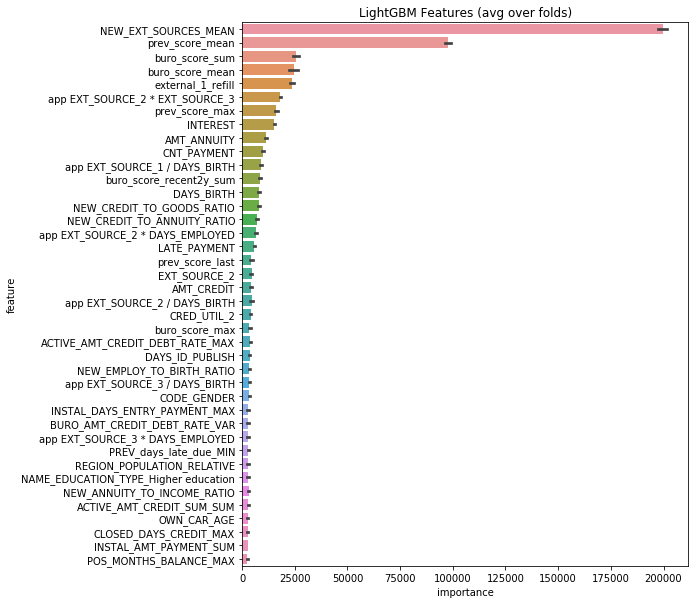

In [13]:
def main(debug = False):
    num_rows = 20000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.merge(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.merge(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df
        
if __name__ == "__main__":
    submission_file_name = "submission_with selected_features.csv"
    with timer("Full model run"):
        df=main()
    with timer("Starting kfold lightgbm"):
        print(df.shape)
        df.drop(features_with_no_imp_at_least_twice, axis=1, inplace=True)
        gc.collect()
        print(df.shape)
        df.to_csv('o_full_train')
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False)